# 🔍 AI‑vs‑Human Image Authenticity — Baseline Exploration & Models
Detecting AI‑generated imagery is becoming crucial for journalism, copyright, and security.  
In this notebook we:

1. **Acquire & verify the dataset** (Shutterstock real vs. SOTA generative samples).  
2. **Explore the data visually** to understand class balance and artefacts.  
3. **Build three models** — a scratch CNN, a ResNet‑18 transfer‑learning head, and a fine‑tuned EfficientNet‑B0.  
4. **Compare their performance** on a held‑out validation set and produce a Kaggle‑ready submission.


## 1  Environment & Imports
We keep all heavy imports in one place for reproducibility and easier dependency management.


In [1]:
!pip install torchmetrics kagglehub --quiet

In [2]:
import os, random, pathlib, warnings, itertools, math, json, shutil
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from PIL import Image

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchvision import transforms, models
from torchmetrics import Accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score, roc_curve, confusion_matrix,
)
import kagglehub
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
SEED = 42
torch.manual_seed(SEED); random.seed(SEED); np.random.seed(SEED)
torch.backends.cudnn.benchmark = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2  Download the Dataset
We pull the latest version straight from Kaggle Hub (cached on Colab / Kaggle).  
The helper returns the local path where the files were extracted.


In [3]:
DATA_ROOT = pathlib.Path(
    kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")
)
print("📂 Dataset at:", DATA_ROOT)
assert (DATA_ROOT/'train.csv').exists() and (DATA_ROOT/'test.csv').exists()

📂 Dataset at: /kaggle/input/ai-vs-human-generated-dataset


## 3  Data‑Integrity Check
Before training, ensure every file referenced in the CSV actually exists on disk.


In [4]:
train_df = pd.read_csv(DATA_ROOT/'train.csv', index_col=0)
test_df  = pd.read_csv(DATA_ROOT/'test.csv')

def missing_files(df, col, folder):
    paths = [DATA_ROOT/p for p in df[col]]
    return [p for p in paths if not p.exists()]

miss_train = missing_files(train_df, 'file_name', 'train_data')
miss_test  = missing_files(test_df,  'id',        'test_data_v2')
print(f"Missing in train: {len(miss_train)}, in test: {len(miss_test)}")
assert not miss_train and not miss_test, "❗ Some images are missing!"

Missing in train: 0, in test: 0


## 4  Exploratory Data Analysis (EDA)
We’ll look at label distribution, image dimensions, and sample thumbnails.


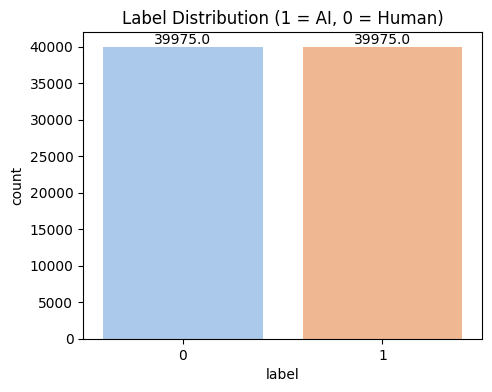

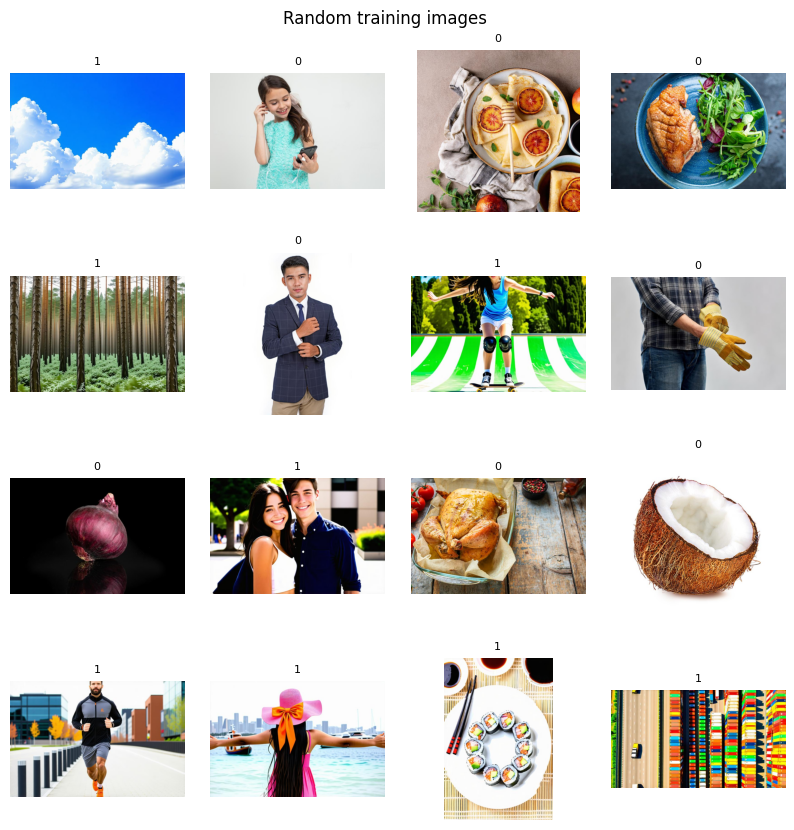

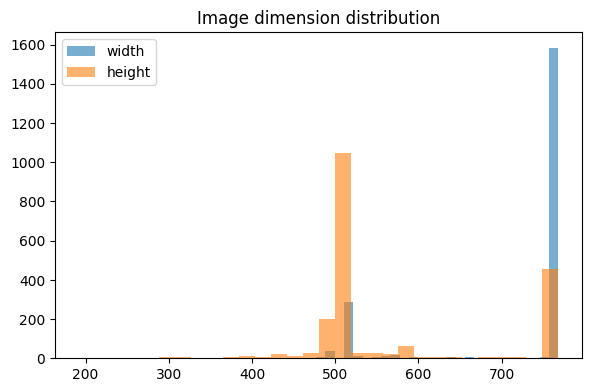

In [5]:
# 4.1 Label distribution ────────────────────────────────────────────
plt.figure(figsize=(5,4))
ax = sns.countplot(x='label', data=train_df, palette='pastel')
for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2, p.get_height(), p.get_height(),
            ha='center', va='bottom')
ax.set_title('Label Distribution (1 = AI, 0 = Human)')
plt.tight_layout(pad=1.0)
plt.show()

# 4.2 Sample grid ────────────────────────────────────────────────────
SAMPLES = 16
rand = train_df.sample(SAMPLES)[['file_name','label']].values

fig, axes = plt.subplots(4, 4, figsize=(10,10))
for ax, (path, label) in zip(axes.flatten(), rand):
    with Image.open(DATA_ROOT/path) as img:
        ax.imshow(img)
    ax.set_title(label, fontsize=8)
    ax.axis('off')

plt.suptitle("Random training images", y=0.92)
plt.subplots_adjust(wspace=0.15, hspace=0.25)
plt.show()

# 4.3 Image‑size distribution ────────────────────────────────────────
dims = [Image.open(DATA_ROOT/p).size for p in train_df['file_name'].sample(2000)]
w,h = zip(*dims)

plt.figure(figsize=(6,4))
plt.hist(w, 30, alpha=.6, label='width')
plt.hist(h, 30, alpha=.6, label='height')
plt.legend(); plt.title('Image dimension distribution')
plt.tight_layout(pad=1.0)
plt.show()

## 5  Dataset Split & Dataloaders
We use an 80 / 20 stratified split.  
Transforms follow ImageNet‑style preprocessing; only training receives augmentation.


In [13]:
# 5.1 Split ─────────────────────────────────────────────────────────────
train_df, val_df = train_test_split(
    train_df, test_size=0.20,
    stratify=train_df['label'], random_state=SEED
)

# 5.2 Transforms ────────────────────────────────────────────────────────
IMNET_MEAN, IMNET_STD = (0.485,0.456,0.406), (0.229,0.224,0.225)
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.75,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(IMNET_MEAN, IMNET_STD),
])
val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMNET_MEAN, IMNET_STD),
])

# 5.2.1  custom dataset  ────────────────────────────────────────────────
class ImageDataset(Dataset):
    def __init__(self, df, root, col, tf, with_labels=True):
        self.paths  = df[col].values
        self.labels = df['label'].values if with_labels else None
        self.root   = root
        self.tf     = tf

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        with Image.open(self.root / self.paths[idx]).convert('RGB') as img:
            img = self.tf(img) if self.tf else img
        if self.labels is None:
            return img, self.paths[idx]
        return img, torch.tensor(self.labels[idx]).long()

# 5.3 Dataloaders ───────────────────────────────────────────────────────
BATCH        = 256
NUM_WORKERS  = 32
PIN_MEMORY   = DEVICE.type == "cuda"
PERSISTENT   = True

def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    torch.manual_seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

train_dl = DataLoader(
    ImageDataset(train_df, DATA_ROOT, 'file_name', train_tf),
    batch_size=BATCH, shuffle=True,
    num_workers=NUM_WORKERS, prefetch_factor=4,  pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT, drop_last=True,
    generator=g, worker_init_fn=seed_worker
)

val_dl = DataLoader(
    ImageDataset(val_df, DATA_ROOT, 'file_name', val_tf),
    batch_size=BATCH*2, shuffle=False,
    num_workers=NUM_WORKERS, prefetch_factor=4,  pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT,
    generator=g, worker_init_fn=seed_worker
)

## 6  Reusable Training & Evaluation Utilities
One loop to rule them all — so the three models share exactly the same training logic and metrics.


In [ ]:
class Trainer:
    """
    Trainer with:
        • accuracy / precision / recall / F1 / AUC logging
        • optional early‑stopping & checkpoint saving
        • automatic mixed‑precision (AMP) for speed
    """

    def __init__(self, model, *, epochs=10, lr=3e-4, wd=1e-4):
        self.model   = model.to(DEVICE)
        self.epochs  = epochs
        self.crit    = nn.CrossEntropyLoss()
        self.opt     = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
        self.acc_m   = Accuracy(task="multiclass", num_classes=2).to(DEVICE)
        self.scaler  = GradScaler()                 # ← AMP gradient scaler
        self.best_path = None

    # ── one epoch helper ────────────────────────────────────────────
    def _epoch(self, loader, train=True):
        self.model.train() if train else self.model.eval()
        bar = tqdm(loader, leave=False, desc="train" if train else "valid")

        tot_loss, seen = 0, 0
        self.acc_m.reset()
        y_true, y_prob = [], []

        for xb, yb in bar:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            if train: self.opt.zero_grad()

            with torch.set_grad_enabled(train):
                with autocast():                            
                    out  = self.model(xb)
                    loss = self.crit(out, yb)

                if train:
                    self.scaler.scale(loss).backward()
                    self.scaler.step(self.opt)
                    self.scaler.update()

            bsz = xb.size(0)
            tot_loss += loss.item() * bsz
            seen     += bsz

            probs = out.softmax(1)[:, 1].detach().cpu()
            y_true.append(yb.cpu())
            y_prob.append(probs)
            self.acc_m.update(out, yb)

            bar.set_postfix(loss=tot_loss/seen,
                            acc=self.acc_m.compute().item())

        y_true = torch.cat(y_true)
        y_prob = torch.cat(y_prob)
        y_pred = (y_prob > 0.5).long()

        prec, rec, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average="binary", zero_division=0
        )
        auc = roc_auc_score(y_true, y_prob)

        return (
            tot_loss/seen,               # 0  loss
            self.acc_m.compute().item(), # 1  accuracy
            prec, rec, f1, auc,          # 2‑5 metrics
            y_true, y_pred, y_prob       # 6‑8 tensors
        )

    # ── full training loop with early‑stopping ───────────────────────
    def fit(
        self,
        train_dl,
        val_dl,
        *,
        tag="model",
        patience=None,           # int or None
        ckpt_dir=".",            # folder for best weights
    ):
        hist = {k: [] for k in (
            "tr_loss","tr_acc","va_loss","va_acc",
            "prec","rec","f1","auc"
        )}
        hist["y_true"] = hist["y_pred"] = hist["y_prob"] = None

        best_acc, wait = 0, 0

        for ep in range(1, self.epochs + 1):
            tr = self._epoch(train_dl, train=True)
            va = self._epoch(val_dl,   train=False)

            # record metrics
            hist["tr_loss"].append(tr[0]); hist["tr_acc"].append(tr[1])
            hist["va_loss"].append(va[0]); hist["va_acc"].append(va[1])
            hist["prec"].append(va[2]);    hist["rec"].append(va[3])
            hist["f1"].append(va[4]);      hist["auc"].append(va[5])
            hist["y_true"], hist["y_pred"], hist["y_prob"] = va[6:]

            print(
                f"{tag} | epoch {ep:02d} | "
                f"train loss={tr[0]:.4f} acc={tr[1]:.4f} | "
                f"val loss={va[0]:.4f} acc={va[1]:.4f} "
                f"prec={va[2]:.4f} rec={va[3]:.4f} "
                f"f1={va[4]:.4f} auc={va[5]:.4f}"
            )

            # early‑stopping
            if patience is not None:
                if va[1] > best_acc:
                    best_acc, wait = va[1], 0
                    path = pathlib.Path(ckpt_dir) / f"{tag}_best.pth"
                    path.parent.mkdir(parents=True, exist_ok=True)
                    torch.save(self.model.state_dict(), path)
                    self.best_path = str(path)
                else:
                    wait += 1
                    if wait == patience:
                        print(f"[Early‑stop] epoch {ep:02d} "
                              f"(best acc {best_acc:.4f})")
                        break

        return hist

## 7  Model A — Scratch CNN
A lightweight 5‑layer conv‑net as a quick baseline.


In [ ]:
class TinyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,1,1),  nn.BatchNorm2d(32),  nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,1,1),  nn.BatchNorm2d(64),  nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,1,1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128,256,3,1,1),nn.BatchNorm2d(256), nn.ReLU(), nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Linear(256, 2)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x).flatten(1)
        return self.classifier(x)

cnn = TinyCNN()

# create the trainer object first
trainer_cnn = Trainer(cnn, epochs=10, lr=1e-3)

# run training / early‑stopping
hist_cnn = trainer_cnn.fit(
    train_dl, val_dl,
    tag="CNN",
    patience=2,
    ckpt_dir="checkpoints"
)

print("Best CNN weights saved at:", trainer_cnn.best_path)

train:   0%|          | 0/249 [00:00<?, ?it/s]

valid:   0%|          | 0/32 [00:01<?, ?it/s]

CNN | epoch 01 | train loss=0.2578 acc=0.8954 | val loss=0.2271 acc=0.9114 prec=0.9103 rec=0.9127 f1=0.9115 auc=0.9694


train:   0%|          | 0/249 [00:00<?, ?it/s]

valid:   0%|          | 0/32 [00:00<?, ?it/s]

CNN | epoch 02 | train loss=0.1941 acc=0.9250 | val loss=0.1977 acc=0.9235 prec=0.9254 rec=0.9212 f1=0.9233 auc=0.9769


train:   0%|          | 0/249 [00:00<?, ?it/s]

valid:   0%|          | 0/32 [00:00<?, ?it/s]

CNN | epoch 03 | train loss=0.1701 acc=0.9357 | val loss=0.1853 acc=0.9272 prec=0.9624 rec=0.8892 f1=0.9243 auc=0.9827


train:   0%|          | 0/249 [00:00<?, ?it/s]

valid:   0%|          | 0/32 [00:00<?, ?it/s]

CNN | epoch 04 | train loss=0.1548 acc=0.9416 | val loss=0.1776 acc=0.9296 prec=0.9704 rec=0.8862 f1=0.9264 auc=0.9854


train:   0%|          | 0/249 [00:00<?, ?it/s]

valid:   0%|          | 0/32 [00:00<?, ?it/s]

CNN | epoch 05 | train loss=0.1491 acc=0.9438 | val loss=0.1850 acc=0.9303 prec=0.9509 rec=0.9074 f1=0.9286 auc=0.9816


train:   0%|          | 0/249 [00:00<?, ?it/s]

valid:   0%|          | 0/32 [00:00<?, ?it/s]

CNN | epoch 06 | train loss=0.1382 acc=0.9475 | val loss=0.1829 acc=0.9266 prec=0.9700 rec=0.8804 f1=0.9230 auc=0.9848


train:   0%|          | 0/249 [00:00<?, ?it/s]

valid:   0%|          | 0/32 [00:00<?, ?it/s]

CNN | epoch 07 | train loss=0.1319 acc=0.9499 | val loss=0.2304 acc=0.9070 prec=0.9832 rec=0.8281 f1=0.8990 auc=0.9864
[Early‑stop] epoch 07 (best acc 0.9303)
Best CNN weights saved at: checkpoints/CNN_best.pth


## 8  Model B — ResNet‑18 Transfer Learning
We freeze early layers and retrain the classifier head for speed.


In [ ]:
# ── ResNet‑18 fine‑tune: unfreeze layer4 only ─────────────────────────
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# freeze everything first
for p in resnet.parameters():
    p.requires_grad = False

# unfreeze last block (layer4) + classifier head
for p in resnet.layer4.parameters():
    p.requires_grad = True

resnet.fc = nn.Linear(resnet.fc.in_features, 2)   # new head is trainable by default

# lock BatchNorm running‑stats in the frozen layers
for name, m in resnet.named_modules():
    if isinstance(m, nn.BatchNorm2d) and not name.startswith("layer4"):
        m.eval()
        m.requires_grad_(False)

# ── Trainer with custom param groups ──────────────────────────────────
trainer_res = Trainer(resnet, epochs=20, lr=1e-3)

# replace its optimizer with two groups
trainer_res.opt = torch.optim.AdamW(
    [
        {'params': resnet.layer4.parameters(), 'lr': 3e-4},   # conservative
        {'params': resnet.fc.parameters(),    'lr': 1e-3},   # faster for new head
    ],
    weight_decay=1e-4
)

hist_res = trainer_res.fit(
    train_dl, val_dl,
    tag="ResNet‑18",
    patience=2,
    ckpt_dir="checkpoints"
)

print("Best ResNet weights:", trainer_res.best_path)

train:   0%|          | 0/199 [00:01<?, ?it/s]

valid:   0%|          | 0/25 [00:01<?, ?it/s]

ResNet‑18 | epoch 01 | train loss=0.1082 acc=0.9564 | val loss=0.0904 acc=0.9635 prec=0.9487 rec=0.9800 f1=0.9641 auc=0.9960


train:   0%|          | 0/199 [00:00<?, ?it/s]

valid:   0%|          | 0/25 [00:00<?, ?it/s]

ResNet‑18 | epoch 02 | train loss=0.0510 acc=0.9803 | val loss=0.0646 acc=0.9755 prec=0.9716 rec=0.9795 f1=0.9756 auc=0.9977


train:   0%|          | 0/199 [00:00<?, ?it/s]

valid:   0%|          | 0/25 [00:00<?, ?it/s]

ResNet‑18 | epoch 03 | train loss=0.0379 acc=0.9855 | val loss=0.0526 acc=0.9798 prec=0.9853 rec=0.9742 f1=0.9797 auc=0.9984


train:   0%|          | 0/199 [00:00<?, ?it/s]

valid:   0%|          | 0/25 [00:00<?, ?it/s]

ResNet‑18 | epoch 04 | train loss=0.0271 acc=0.9903 | val loss=0.0606 acc=0.9785 prec=0.9837 rec=0.9731 f1=0.9784 auc=0.9982


train:   0%|          | 0/199 [00:00<?, ?it/s]

valid:   0%|          | 0/25 [00:00<?, ?it/s]

ResNet‑18 | epoch 05 | train loss=0.0236 acc=0.9910 | val loss=0.0598 acc=0.9785 prec=0.9784 rec=0.9786 f1=0.9785 auc=0.9981
[Early‑stop] epoch 05 (best acc 0.9798)
Best ResNet weights: checkpoints/ResNet‑18_best.pth


## 9  Model C — EfficientNet‑B0 Fine‑Tuning
Reference implementation adapted from the Kaggle snippet (early‑stopping included).


In [ ]:
# EfficientNet‑B0 fine‑tune (freeze all but last 3 blocks + classifier)
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

eff = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
eff.classifier[1] = nn.Linear(eff.classifier[1].in_features, 2)

for p in eff.parameters():                    p.requires_grad = False
for p in eff.features[-3:].parameters():      p.requires_grad = True
for p in eff.classifier.parameters():         p.requires_grad = True

# freeze BatchNorm stats outside the unfrozen blocks
for name, m in eff.named_modules():
    if isinstance(m, nn.BatchNorm2d) and not name.startswith("features.6"):
        m.eval(); m.requires_grad_(False)

# ── train with early‑stopping & full metric printout ────────────────
trainer_eff = Trainer(eff, epochs=20, lr=1e-3)
hist_eff    = trainer_eff.fit(
    train_dl, val_dl,
    tag="EffNet‑B0",
    patience=3,           
    ckpt_dir="checkpoints"
)

print("Best EfficientNet weights:", trainer_eff.best_path)

train:   0%|          | 0/199 [00:00<?, ?it/s]

valid:   0%|          | 0/25 [00:00<?, ?it/s]

EffNet‑B0 | epoch 01 | train loss=0.1080 acc=0.9552 | val loss=0.0700 acc=0.9726 prec=0.9551 rec=0.9917 f1=0.9731 auc=0.9980


train:   0%|          | 0/199 [00:00<?, ?it/s]

valid:   0%|          | 0/25 [00:00<?, ?it/s]

EffNet‑B0 | epoch 02 | train loss=0.0489 acc=0.9813 | val loss=0.0569 acc=0.9773 prec=0.9658 rec=0.9897 f1=0.9776 auc=0.9984


train:   0%|          | 0/199 [00:00<?, ?it/s]

valid:   0%|          | 0/25 [00:00<?, ?it/s]

EffNet‑B0 | epoch 03 | train loss=0.0384 acc=0.9857 | val loss=0.0453 acc=0.9844 prec=0.9766 rec=0.9928 f1=0.9846 auc=0.9991


train:   0%|          | 0/199 [00:00<?, ?it/s]

valid:   0%|          | 0/25 [00:00<?, ?it/s]

EffNet‑B0 | epoch 04 | train loss=0.0305 acc=0.9882 | val loss=0.0418 acc=0.9853 prec=0.9830 rec=0.9876 f1=0.9853 auc=0.9989


train:   0%|          | 0/199 [00:00<?, ?it/s]

valid:   0%|          | 0/25 [00:00<?, ?it/s]

EffNet‑B0 | epoch 05 | train loss=0.0244 acc=0.9905 | val loss=0.0342 acc=0.9873 prec=0.9851 rec=0.9895 f1=0.9873 auc=0.9993


train:   0%|          | 0/199 [00:00<?, ?it/s]

valid:   0%|          | 0/25 [00:00<?, ?it/s]

EffNet‑B0 | epoch 06 | train loss=0.0236 acc=0.9909 | val loss=0.0456 acc=0.9842 prec=0.9935 rec=0.9748 f1=0.9841 auc=0.9991


train:   0%|          | 0/199 [00:00<?, ?it/s]

valid:   0%|          | 0/25 [00:00<?, ?it/s]

EffNet‑B0 | epoch 07 | train loss=0.0200 acc=0.9927 | val loss=0.0428 acc=0.9846 prec=0.9759 rec=0.9937 f1=0.9847 auc=0.9992


train:   0%|          | 0/199 [00:00<?, ?it/s]

valid:   0%|          | 0/25 [00:00<?, ?it/s]

EffNet‑B0 | epoch 08 | train loss=0.0178 acc=0.9936 | val loss=0.0407 acc=0.9873 prec=0.9895 rec=0.9851 f1=0.9873 auc=0.9990


train:   0%|          | 0/199 [00:00<?, ?it/s]

valid:   0%|          | 0/25 [00:00<?, ?it/s]

EffNet‑B0 | epoch 09 | train loss=0.0178 acc=0.9935 | val loss=0.0371 acc=0.9874 prec=0.9872 rec=0.9876 f1=0.9874 auc=0.9992


train:   0%|          | 0/199 [00:00<?, ?it/s]

valid:   0%|          | 0/25 [00:00<?, ?it/s]

EffNet‑B0 | epoch 10 | train loss=0.0144 acc=0.9950 | val loss=0.0468 acc=0.9862 prec=0.9820 rec=0.9908 f1=0.9864 auc=0.9988


train:   0%|          | 0/199 [00:00<?, ?it/s]

valid:   0%|          | 0/25 [00:00<?, ?it/s]

EffNet‑B0 | epoch 11 | train loss=0.0171 acc=0.9939 | val loss=0.0467 acc=0.9853 prec=0.9796 rec=0.9914 f1=0.9855 auc=0.9989


train:   0%|          | 0/199 [00:00<?, ?it/s]

valid:   0%|          | 0/25 [00:00<?, ?it/s]

EffNet‑B0 | epoch 12 | train loss=0.0122 acc=0.9956 | val loss=0.0610 acc=0.9816 prec=0.9714 rec=0.9925 f1=0.9818 auc=0.9988
[Early‑stop] epoch 12 (best acc 0.9874)
Best EfficientNet weights: checkpoints/EffNet‑B0_best.pth


## 10  Model Comparison
We plot validation accuracy across epochs and highlight the best‑performing model.


,Best val accuracy
CNN,0.930269
ResNet‑18,0.979831
Eff‑B0,0.987414



=== CNN ===


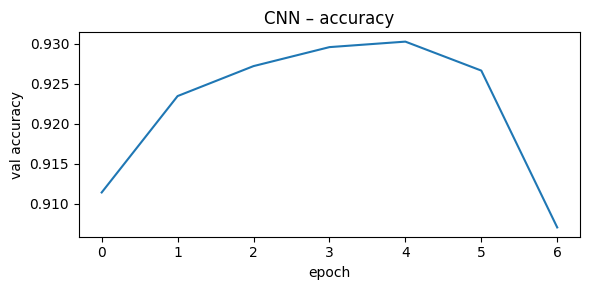

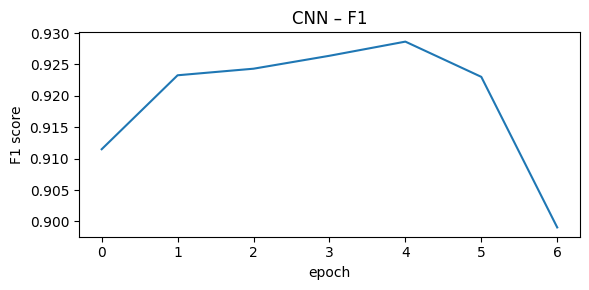

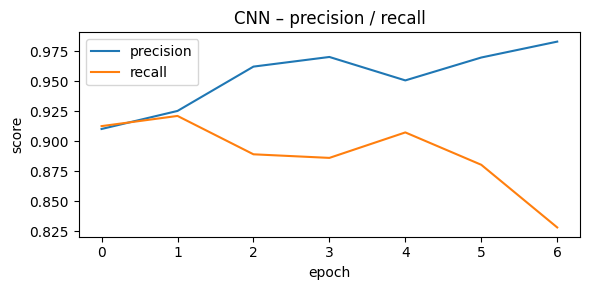

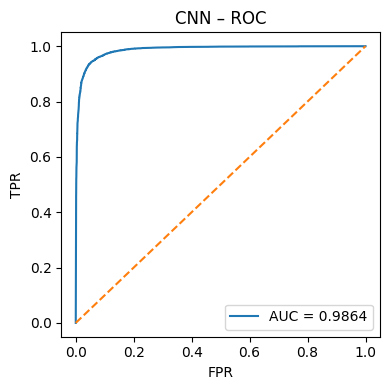

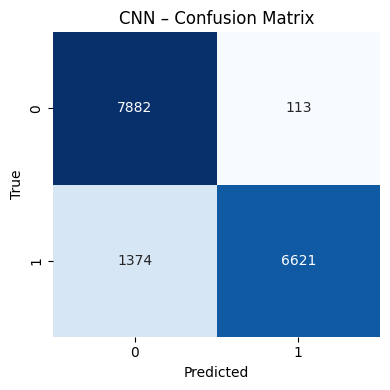


=== ResNet‑18 ===


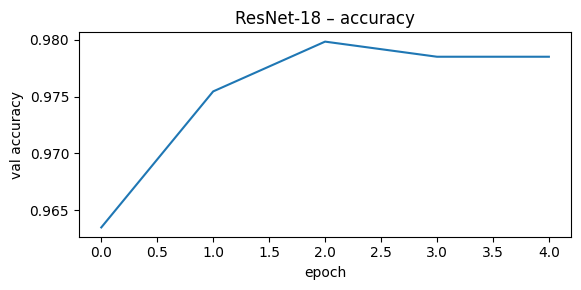

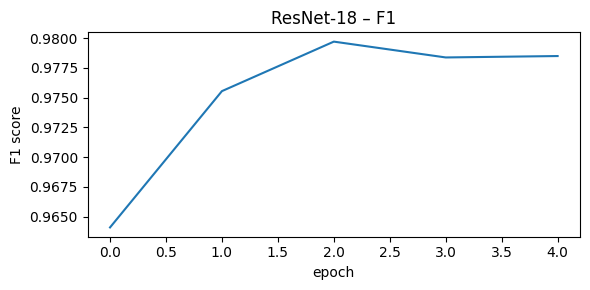

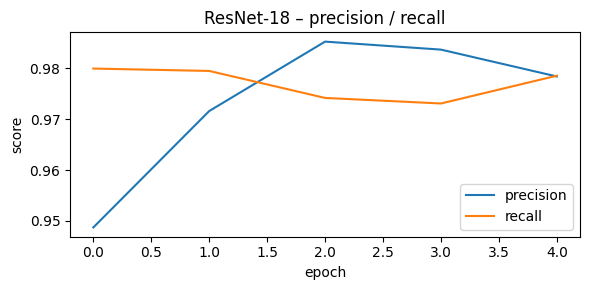

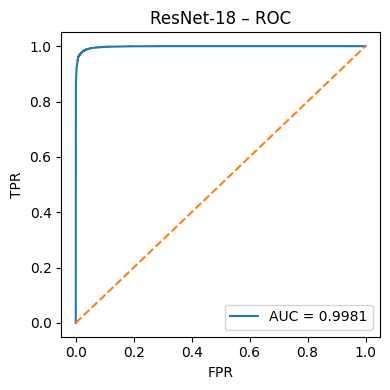

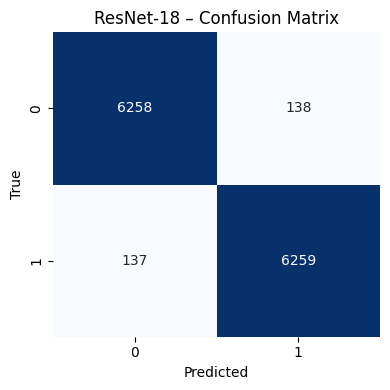


=== Eff‑B0 ===


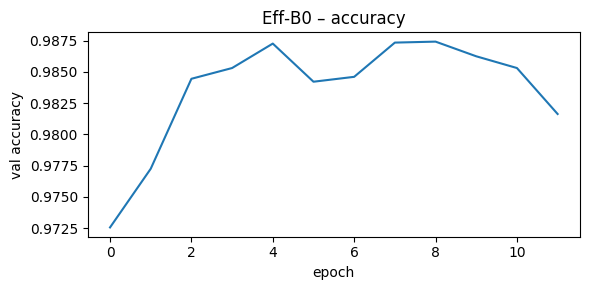

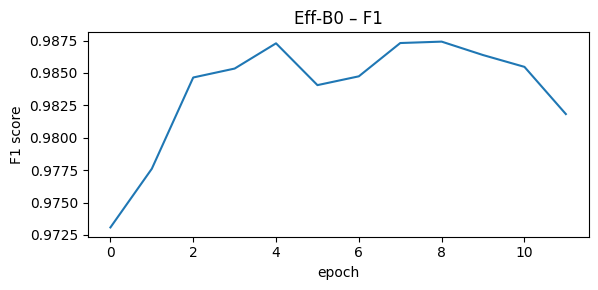

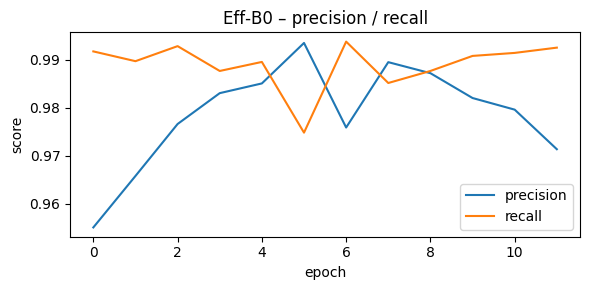

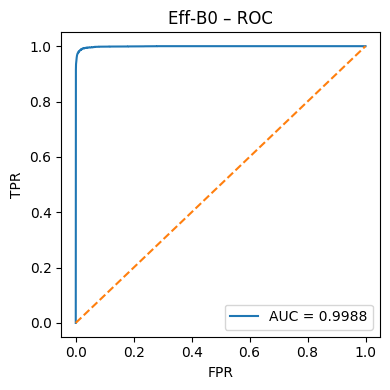

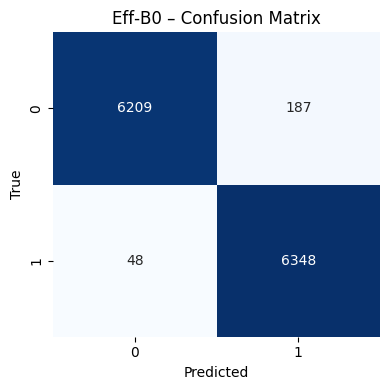

In [ ]:
import pandas as pd
from sklearn.metrics import roc_curve, confusion_matrix, auc as sk_auc

# ── helper -------------------------------------------------------------
def best_val(hist):        
    return max(hist['va_acc'])

# ── 0. summary table ---------------------------------------------------
best_scores = {
    "CNN"       : best_val(hist_cnn),
    "ResNet‑18" : best_val(hist_res),
    "Eff‑B0"    : best_val(hist_eff),
}
display(pd.DataFrame(best_scores, index=['Best val accuracy']).T)

# ── 1‒5. per‑model visualisations -------------------------------------
models_hist = {
    "CNN"      : hist_cnn,
    "ResNet‑18": hist_res,
    "Eff‑B0"   : hist_eff,
}

for name, hist in models_hist.items():
    print(f"\n=== {name} ===")

    # 1. accuracy curve
    plt.figure(figsize=(6,3))
    plt.plot(hist['va_acc'])
    plt.xlabel('epoch'); plt.ylabel('val accuracy'); plt.title(f'{name} – accuracy')
    plt.tight_layout(); plt.show()

    # 2. f1 curve
    plt.figure(figsize=(6,3))
    plt.plot(hist['f1'])
    plt.xlabel('epoch'); plt.ylabel('F1 score'); plt.title(f'{name} – F1')
    plt.tight_layout(); plt.show()

    # 3. precision / recall
    plt.figure(figsize=(6,3))
    plt.plot(hist['prec'], label='precision')
    plt.plot(hist['rec'],  label='recall')
    plt.xlabel('epoch'); plt.ylabel('score')
    plt.title(f'{name} – precision / recall'); plt.legend()
    plt.tight_layout(); plt.show()

    # 4. ROC curve
    y_true = hist['y_true'].numpy()
    y_prob = hist['y_prob'].numpy()
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = sk_auc(fpr, tpr)
    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0,1],[0,1],'--'); plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.title(f'{name} – ROC'); plt.legend(); plt.tight_layout(); plt.show()

    # 5. Confusion matrix
    y_pred = hist['y_pred'].numpy()
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel('Predicted'); ax.set_ylabel('True')
    ax.set_title(f'{name} – Confusion Matrix')
    plt.tight_layout(); plt.show()


## 11 Inference on the Kaggle test set + Preview


inference:   0%|          | 0/22 [00:02<?, ?it/s]

Saved → submission.csv



,id,label
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg,0
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg,0
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg,0
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg,0
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg,0


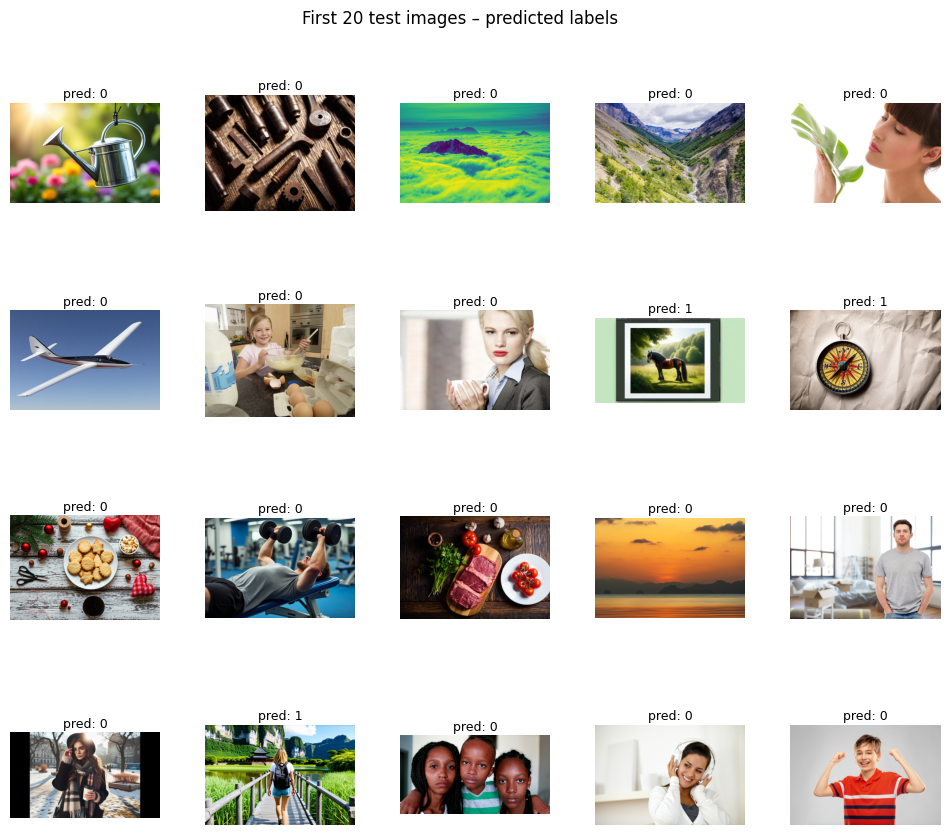

In [ ]:
from tqdm.auto import tqdm
from sklearn.metrics import roc_curve,  auc as sk_auc 

# 11‑1  Dataset & DataLoader ────────────────────────────
test_ds = ImageDataset(
    test_df,                # loaded earlier
    DATA_ROOT,
    col='id',               # column name in test.csv
    tf=val_tf,              # same transforms as validation
    with_labels=False
)
test_dl = DataLoader(
    test_ds, batch_size=256, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT, prefetch_factor=4
)

# 11‑2  Load the best model (EfficientNet‑B0 here) ──────
from torchvision.models import efficientnet_b0

best_model_path = "checkpoints/EffNet‑B0_best.pth"      
model = efficientnet_b0(weights=None)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
model = model.to(DEVICE).eval()

# 11‑3  Predict & build submission.csv ──────────────────
predictions = []
with torch.no_grad():
    for imgs, _ in tqdm(test_dl, leave=False, desc="inference"):
        imgs = imgs.to(DEVICE)
        out  = model(imgs)
        preds = out.argmax(1)                 # same as torch.max(..)[1]
        predictions.extend(preds.cpu().numpy())

submission_df = pd.DataFrame({
    'id'   : test_df.iloc[:, 0],   # first column holds paths
    'label': predictions
})
submission_df.to_csv('submission.csv', index=False)
print("Saved → submission.csv\n")
display(submission_df.head())

# 11‑4  Preview first 20 predictions ────────────────────
SAMPLES = 20
fig, axes = plt.subplots(4, 5, figsize=(12,10))

for ax, (img_path, label) in zip(
        axes.flatten(),
        submission_df.iloc[:SAMPLES].values         
    ):
    with Image.open(DATA_ROOT / img_path) as im:
        ax.imshow(im)
    ax.set_title(f"pred: {label}", fontsize=9, pad=4)   
    ax.axis('off')

plt.suptitle("First 20 test images – predicted labels", y=0.95)
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.show(block=False)   # non‑blocking in Colab
plt.close()             # free memory immediately